# HW 6

In [13]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import glob

In [3]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

89.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



112.7%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



tensor(8)


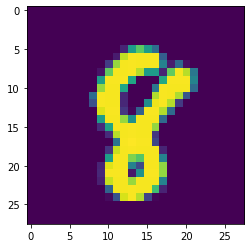

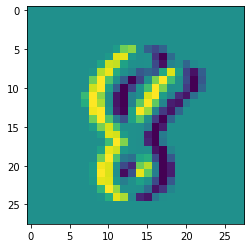

In [4]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

for data, target in train_loader:
    for i in range (1):
        print (target [i])
        img = data [i, 0, :, :]
        plt.imshow (img)
        plt.show ()

        #kernel = np.ones((3, 3),np.float32)
        kernel = np.array([[-1, 0, 1]],np.float32)

        #print (type (img))
        convolved = cv2.filter2D(img.detach().cpu().numpy(),-1,kernel)
        plt.imshow (convolved)
        plt.show ()

    break

In [20]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        # Питон ругался на Dropout2d, рекомендовал использовать просто Dropout
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 1, 28, 28])
        x = self.conv1(x)
        #torch.Size([64, 32, 26, 26])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 12, 12])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 9216])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [21]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive, train=True):
    train_loss = 0

    if (train):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    else:
        model.eval()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
         
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss = test_loss / len(test_loader)
    loss_archive.append (test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287813
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.399219
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.213678
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.307989
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.254505
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.206421
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.279582
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.158864
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.224497
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.132427
Test Epoch: 1 [0/10000 (0%)]	Loss: 0.089121
Test Epoch: 1 [6400/10000 (64%)]	Loss: 0.029565


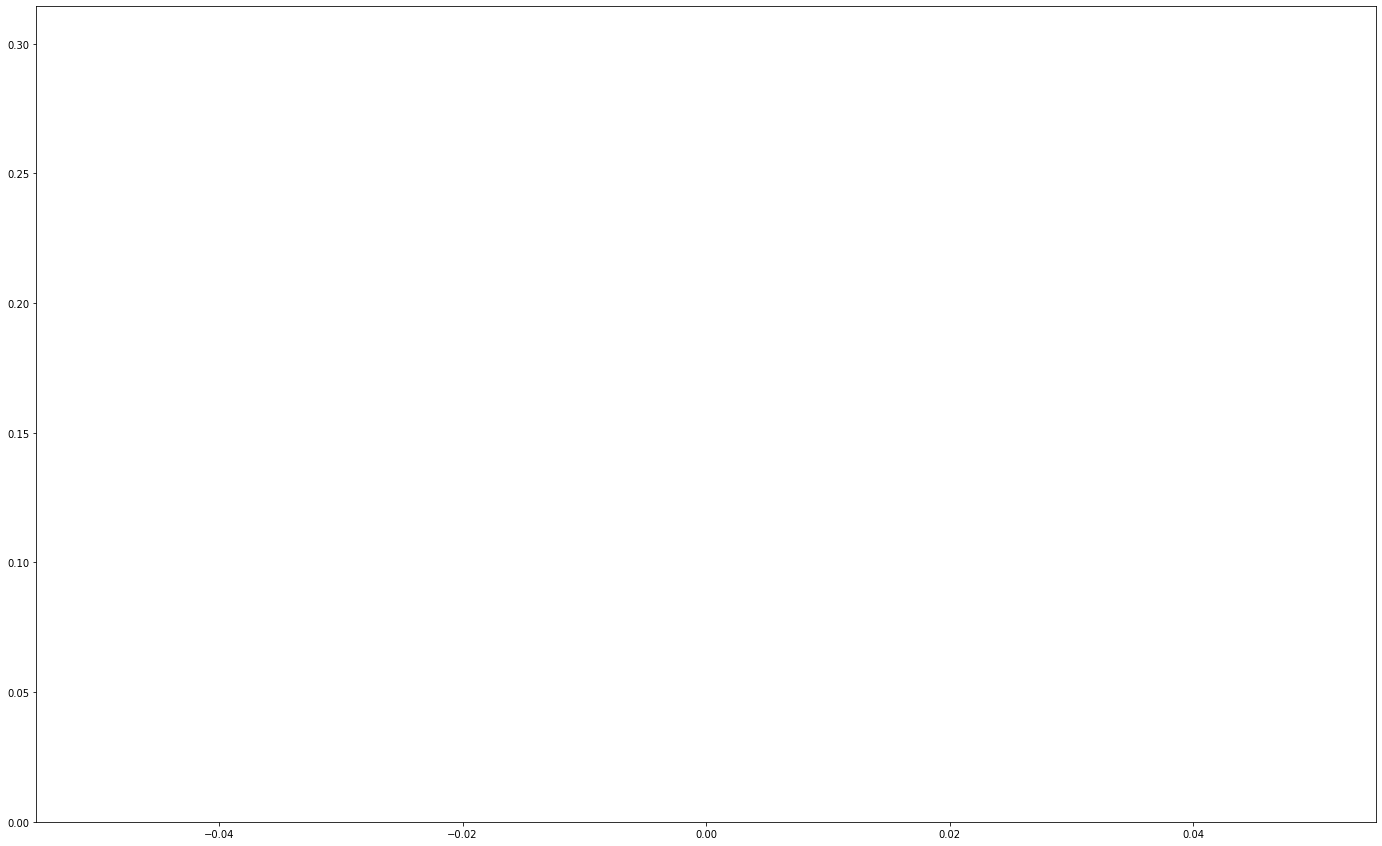

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.085003
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.139899
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.053068
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.195552
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.038998
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.108486
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.077707
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.196006
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.130738
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.082406
Test Epoch: 2 [0/10000 (0%)]	Loss: 0.025550
Test Epoch: 2 [6400/10000 (64%)]	Loss: 0.055269


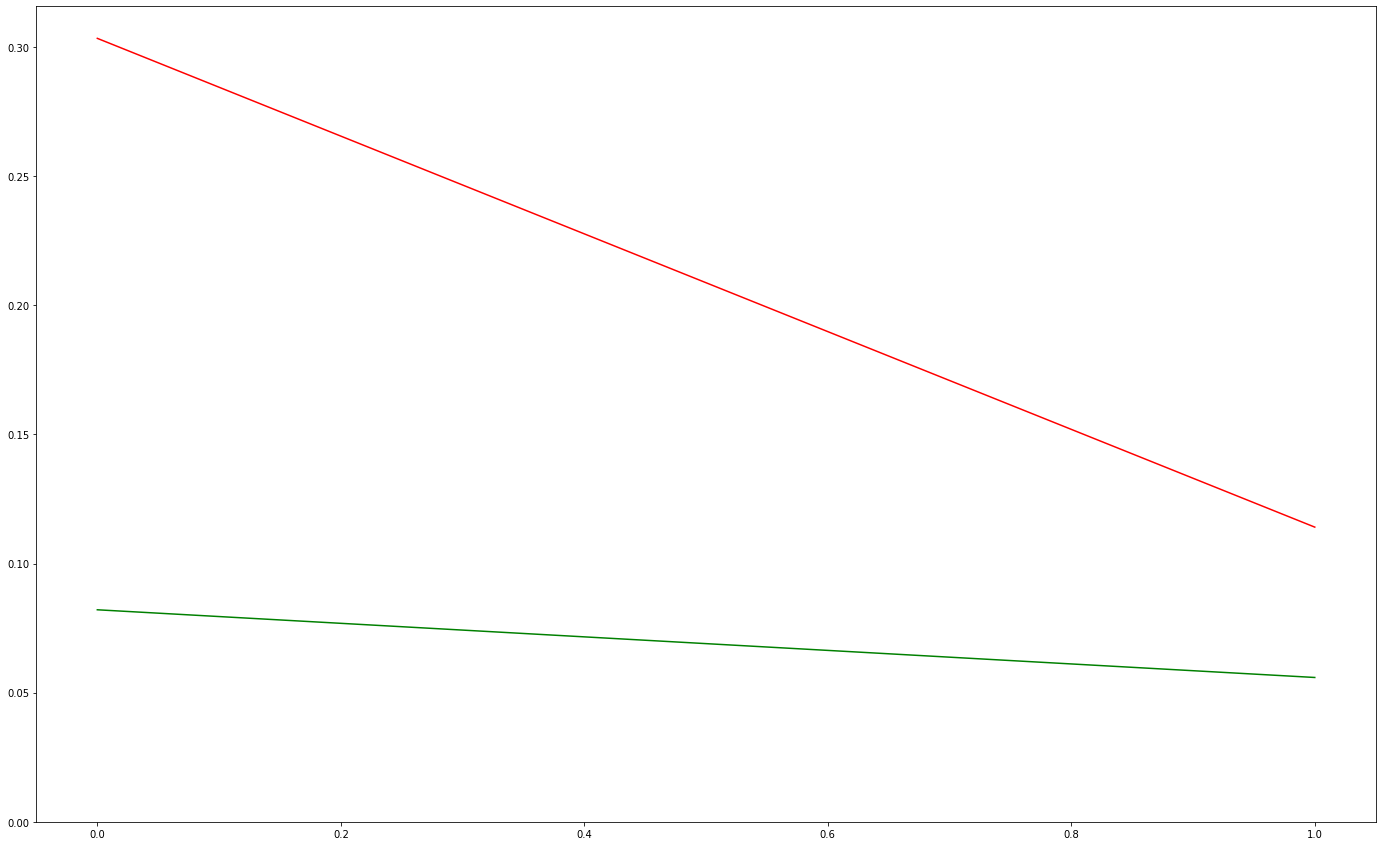

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.078796
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.082251
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.075251
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.032237
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.133742
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.011612
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.012988
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.052897
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.130873
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.101479
Test Epoch: 3 [0/10000 (0%)]	Loss: 0.136193
Test Epoch: 3 [6400/10000 (64%)]	Loss: 0.007950


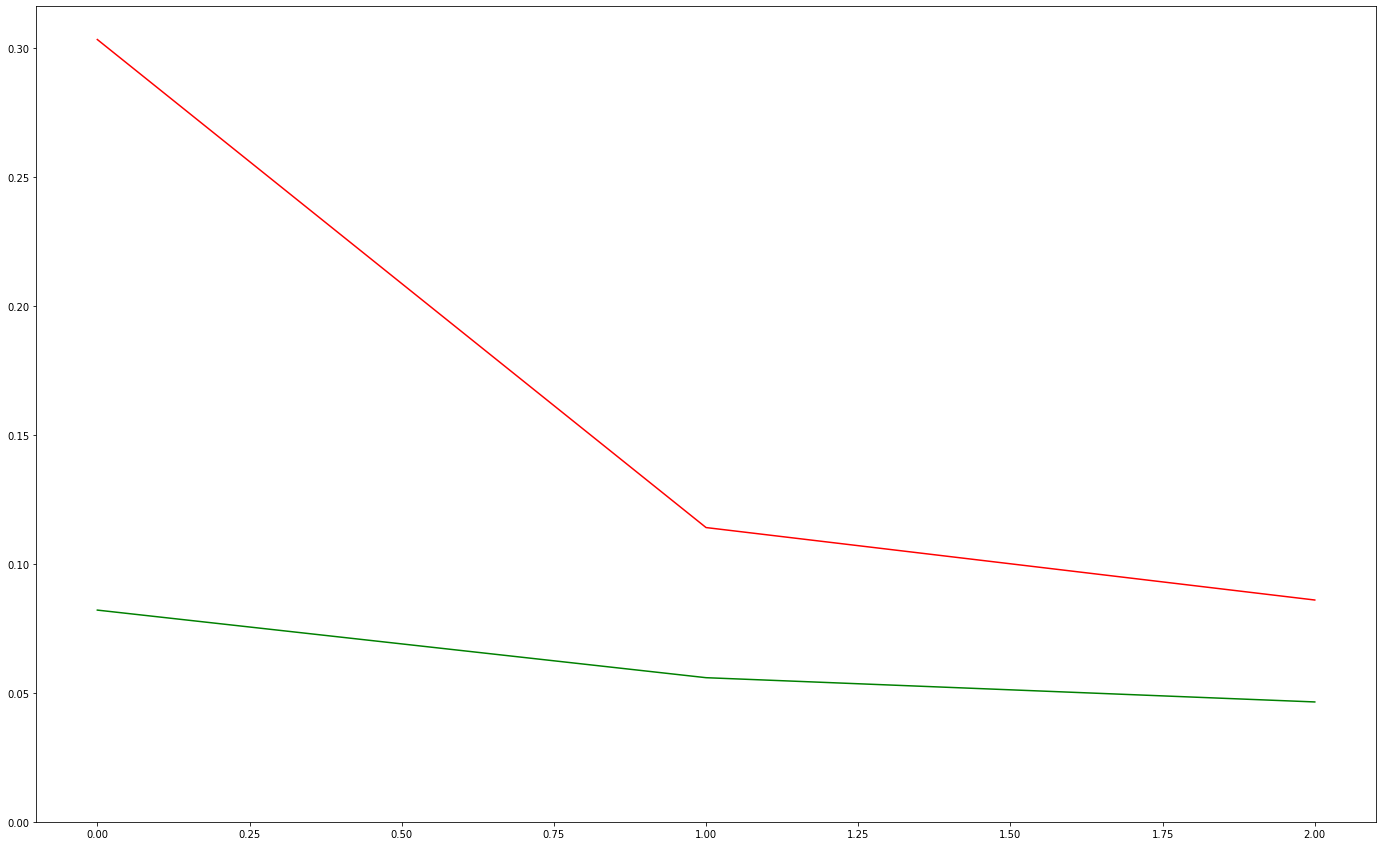

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.077666
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.084821
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.008872
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.164617
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.140464
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.085276
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.013406
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.169121
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.036615
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.019572
Test Epoch: 4 [0/10000 (0%)]	Loss: 0.042110
Test Epoch: 4 [6400/10000 (64%)]	Loss: 0.054850


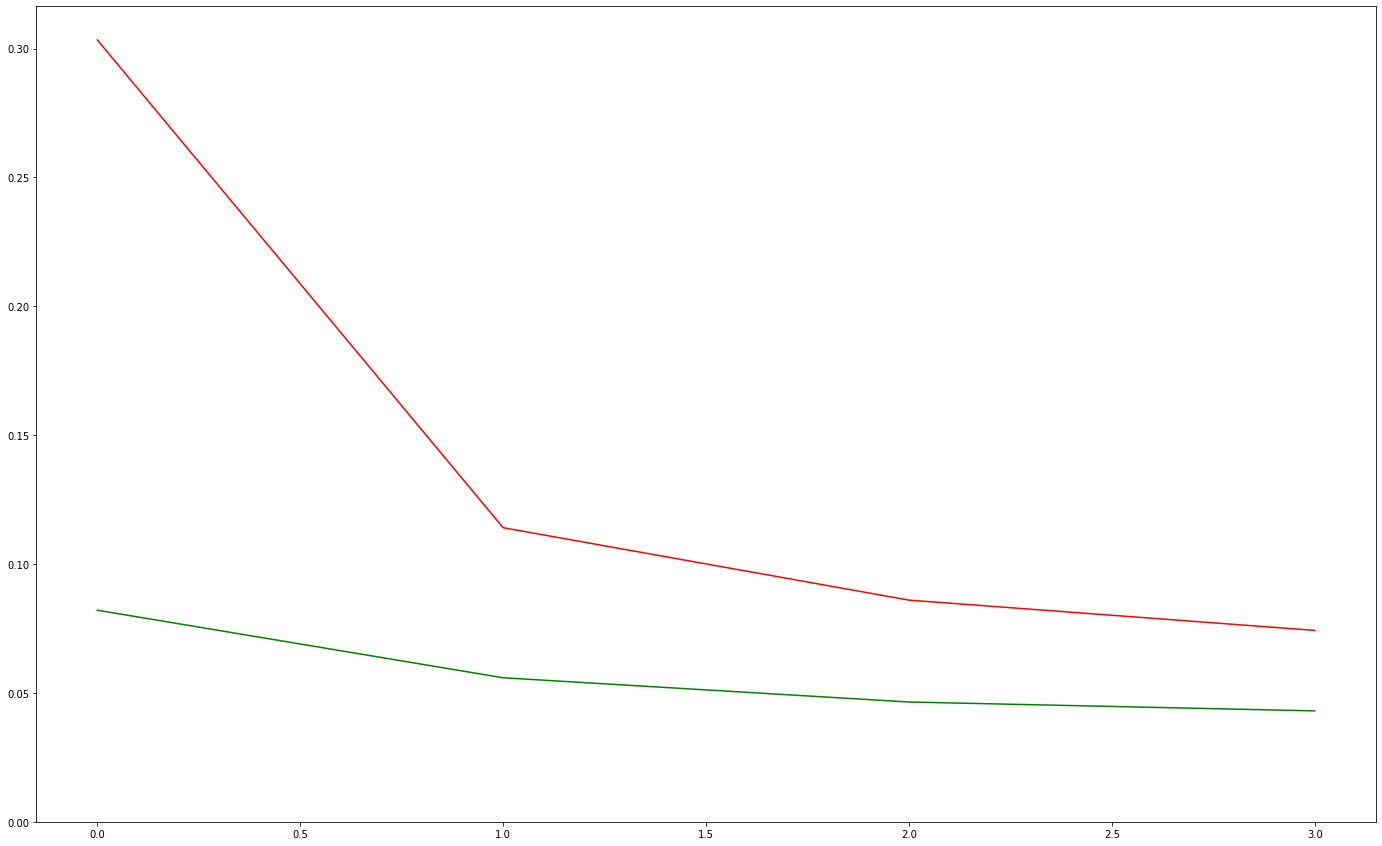

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.117452
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.074193
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.008575
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.060937
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.062004
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.025631
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.056477
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.028919
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.047540
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.161457
Test Epoch: 5 [0/10000 (0%)]	Loss: 0.029230
Test Epoch: 5 [6400/10000 (64%)]	Loss: 0.057095


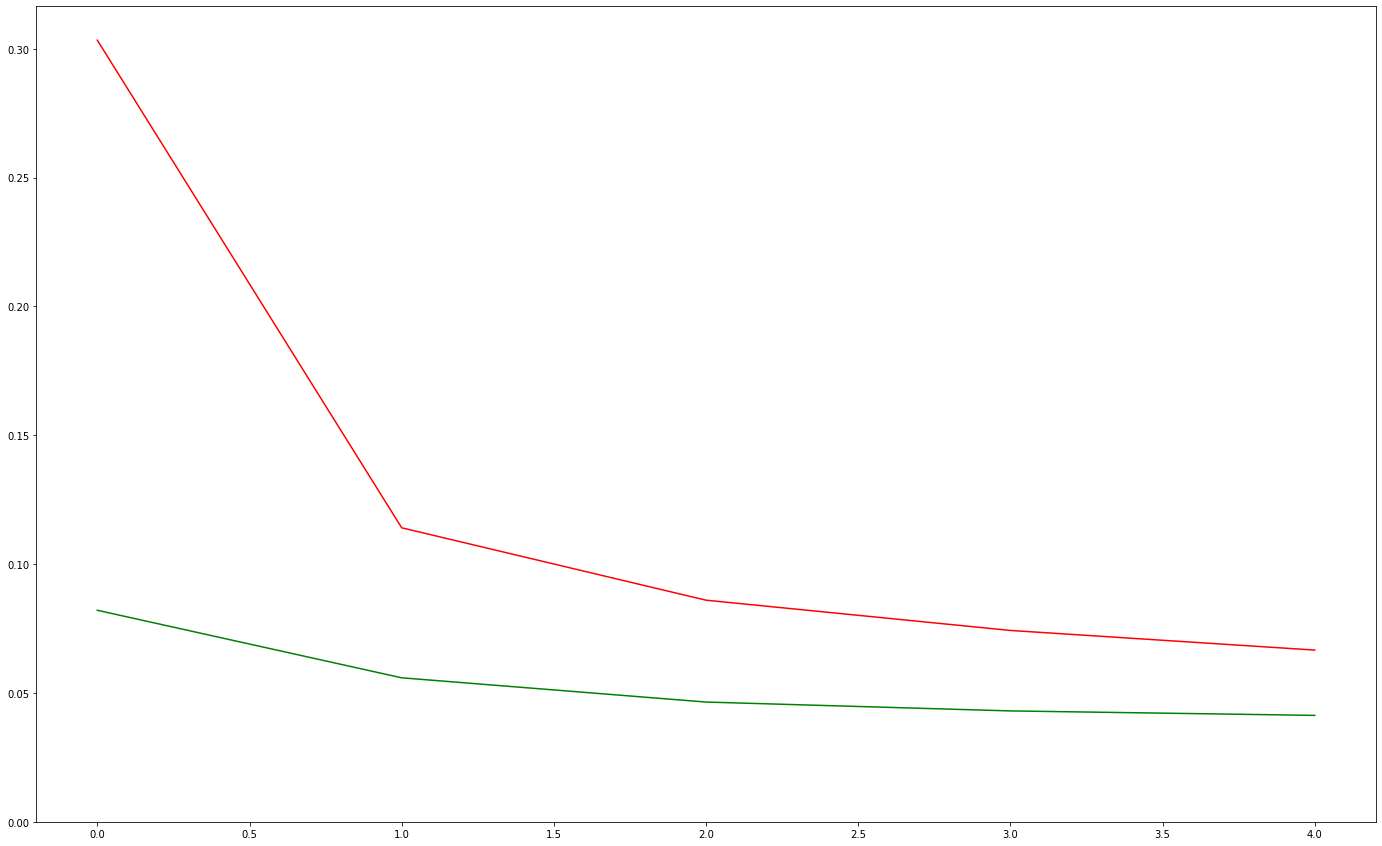

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.019666
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.039541
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.024579
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.098833
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.022439
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.054527
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.066950
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.043475
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.025849
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.085271
Test Epoch: 6 [0/10000 (0%)]	Loss: 0.018030
Test Epoch: 6 [6400/10000 (64%)]	Loss: 0.007464


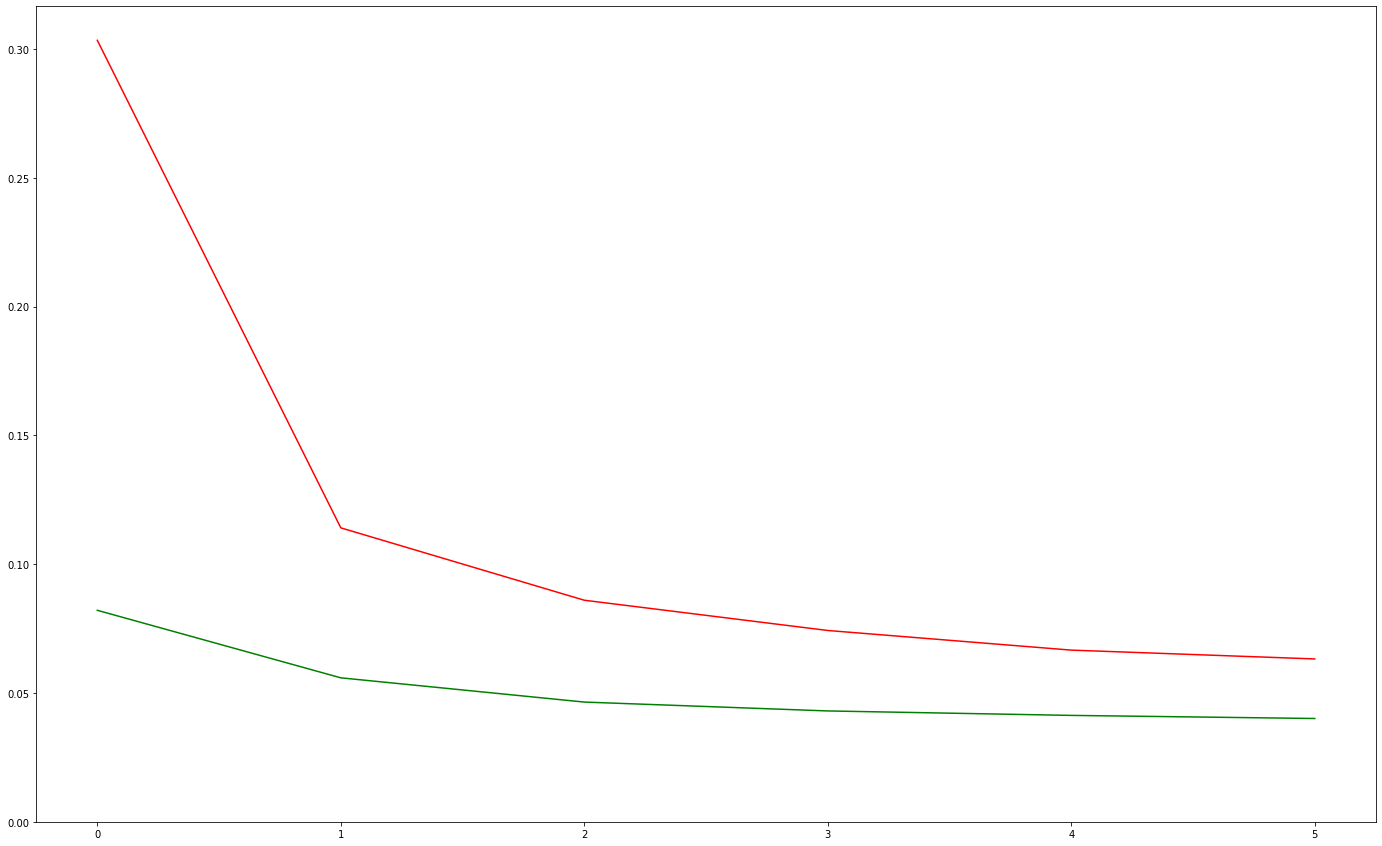

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.243915
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.059261
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.039172
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.049011
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.021649
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.118962
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.027765
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.130805
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.030249
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.017792
Test Epoch: 7 [0/10000 (0%)]	Loss: 0.005678
Test Epoch: 7 [6400/10000 (64%)]	Loss: 0.033292


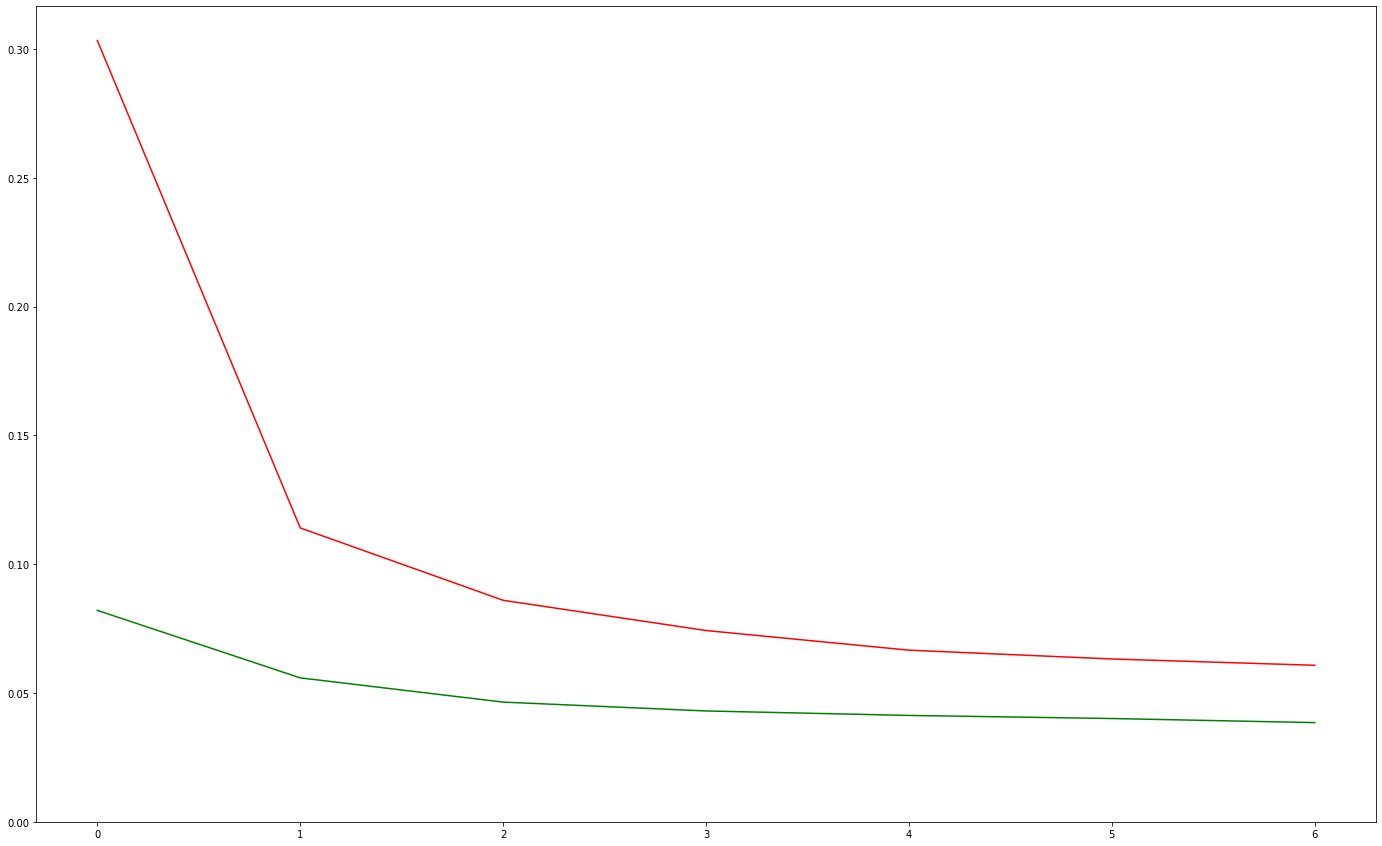

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.017758
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.102690
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.077847
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.016918
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.182996
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.070731
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.005252
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.014271


KeyboardInterrupt: 

In [22]:
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

#model = Simple_net(100, 10).to(device)
model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    train(model, device, test_loader, optimizer, epoch, log_interval, test_loss, False)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

In [12]:
test(model, device, test_loader, test_loss)


Test set: Average loss: 0.0375, Accuracy: 9871/10000 (99%)



# Неудачная попытка использовать обученную нейронку

Я нарисовал цифры в нужном формате, однако не смог их классифицировать. Непонятно, как обходится с батчем, если надо прогнать только одно изображение.

In [ ]:
NUMBERS_FOLDER = "../data/imgs/numbers/"

numbers = glob.glob(NUMBERS_FOLDER + "*.jpg")
convert_tensor = transforms.ToTensor()

tensors = []

for fname in numbers:
    img = Image.open(fname)
    tr = convert_tensor(img)
    tensors.append(tr)

tensors = tensors * 10

#out = model(tensors[:64])
#out[0]

## Save & Load

Немного раскидал код по функциям, чтобы под конец демонстрация была без копипасты и более наглядной.

In [ ]:
def saveEntireModel(model, path):
    torch.save(model.state_dict(), path)

def loadEntireModel(blank_model, path):
    blank_model.load_state_dict(torch.load(path))

def saveCheckpoint(model, optimizer, scheduler, epoch, loss, path):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss,
                }, path)

def loadCheckpoint(blank_model, blank_optimizer, blank_scheduler, path):
    checkpoint = torch.load(path)
    blank_model.load_state_dict(checkpoint['model_state_dict'])
    blank_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    blank_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss    

In [ ]:
epochs          = 1
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

def newBlankTraining():
    model = Simple_net(100, 10).to(device)
    #model = Conv_net().to(device)

    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    return model, optimizer, scheduler

def doTrain(model, optimizer, scheduler, current_epochs=0):

    train_loss = []
    test_loss  = []

    plt.ion()

    for epoch in range(current_epochs + 1, current_epochs + epochs + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
        train(model, device, test_loader, optimizer, epoch, log_interval, test_loss, False)

        # test(model, device, test_loader, test_loss)
        
        scheduler.step()

        #clear_output(wait = True)

    return epochs, test_loss[-1]

Тест сохранения и загрузки всей модели. Обучаем 1 эпоху, печатаем лосс на тесте, сохраняем модель. Чистим переменные, загружаем модель, снова получаем лосс на тесте

In [ ]:
## Load & Save entire model demo

MODEL_PATH = "model.pth"

model, optimizer, scheduler = newBlankTraining()
epoch, loss = doTrain(model, optimizer, scheduler)
print("\nModel trained; test loss:", loss, "    LOOK HERE")

saveEntireModel(model, MODEL_PATH)
print("\nModel saved as '%s'" % MODEL_PATH)

# Erase everything
model, optimizer, scheduler = None, None, None

model, optimizer, scheduler = newBlankTraining()
loadEntireModel(model, MODEL_PATH)
print("Model loaded from '%s'\n" % MODEL_PATH)

test_load = []
train(model, device, test_loader, optimizer, epoch, log_interval, test_load, False)
print("\nLoaded model test loss:", test_load[0], "       LOOK HERE")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293846
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.492722
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.563258
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.488181
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302157
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.315815
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.383990
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.156034
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164482
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.424047


Test Epoch: 1 [0/10000 (0%)]	Loss: 0.307674
Test Epoch: 1 [6400/10000 (64%)]	Loss: 0.211786

Model trained; test loss: 0.24077627938359406     LOOK HERE

Model saved as 'model.pth'
Model loaded from 'model.pth'

Test Epoch: 1 [0/10000 (0%)]	Loss: 0.377937
Test Epoch: 1 [6400/10000 (64%)]	Loss: 0.211637

Loaded model test loss: 0.24145148651804893        LOOK HERE
-----------------------------------


Тест чекпоинта. Для начала прогоняем 2 эпохи и печатаем динамику лосса. Затем чистим переменные, прогоняем 1 эпоху, сохраняем чекпоинт. Снова чистим переменные, загружаем чекпоинт, прогоняем еще одну эпоху. Сравним получившуюся динамику лосса с динамикой, полученной выше. Результаты немного разные, но отрицательный тренд присутствует в обоих случаях.

In [ ]:
CHPT_PATH = "model.chpt"

print("2 epochs continously\n")

# Erase everything
model, optimizer, scheduler, epoch, loss = None, None, None, None, None

model, optimizer, scheduler = newBlankTraining()
_, loss = doTrain(model, optimizer, scheduler)
print("\n")
_, loss = doTrain(model, optimizer, scheduler, 1)
print("\nModel trained (epoch: 2); test loss:", loss)


print("\nReset, 1 epoch, checkpoint, 1 epoch\n")

# Erase everything
model, optimizer, scheduler, epoch, loss = None, None, None, None, None

model, optimizer, scheduler = newBlankTraining()
epoch, loss = doTrain(model, optimizer, scheduler)
print("\nModel trained (epoch: %d); test loss:" % epoch, loss)

saveCheckpoint(model, optimizer, scheduler, epoch, loss, CHPT_PATH)
print("Checkpoint saved as", CHPT_PATH)

# Erase everything
model, optimizer, scheduler, epoch, loss = None, None, None, None, None

model, optimizer, scheduler = newBlankTraining()
epoch, loss = loadCheckpoint(model, optimizer, scheduler, CHPT_PATH) 

print("Checkpoint loaded from %s (epoch: %d)\n" % (CHPT_PATH, epoch))

epoch, loss = doTrain(model, optimizer, scheduler, epoch)

2 epochs continously

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300330
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.561979
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.358150
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.401852
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.347566
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.350318
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.229888
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.320782
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.123401
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.312838


Test Epoch: 1 [0/10000 (0%)]	Loss: 0.279893
Test Epoch: 1 [6400/10000 (64%)]	Loss: 0.220042


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.214462
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.208235
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.142097
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.241626
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.153018
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.129362
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.260281
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.2

# CIFAR-10

In [ ]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


In [ ]:
class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 3, 32, 32])
        x = self.conv1(x)
        #torch.Size([64, 32, 30, 30])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 14, 14])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 12544])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.281025
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.060422
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.841254
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.580245
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.620400
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.508491
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.594658
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.156258
Test Epoch: 1 [0/10000 (0%)]	Loss: 1.254715
Test Epoch: 1 [6400/10000 (64%)]	Loss: 1.431905


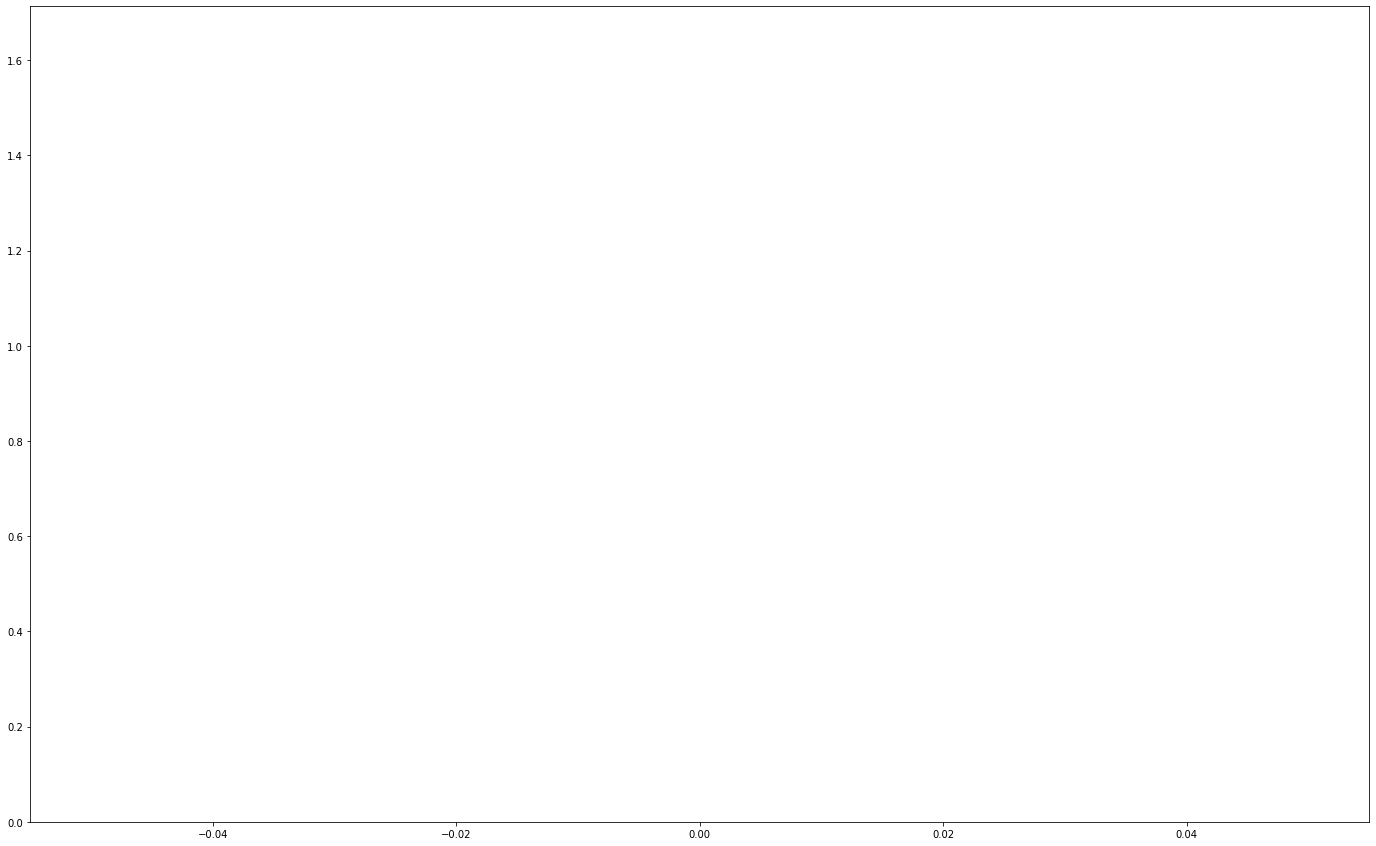

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.330934
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.619761
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.261355
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.583108
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.333725
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.258726
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.257536
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.414340
Test Epoch: 2 [0/10000 (0%)]	Loss: 1.169940
Test Epoch: 2 [6400/10000 (64%)]	Loss: 1.144539


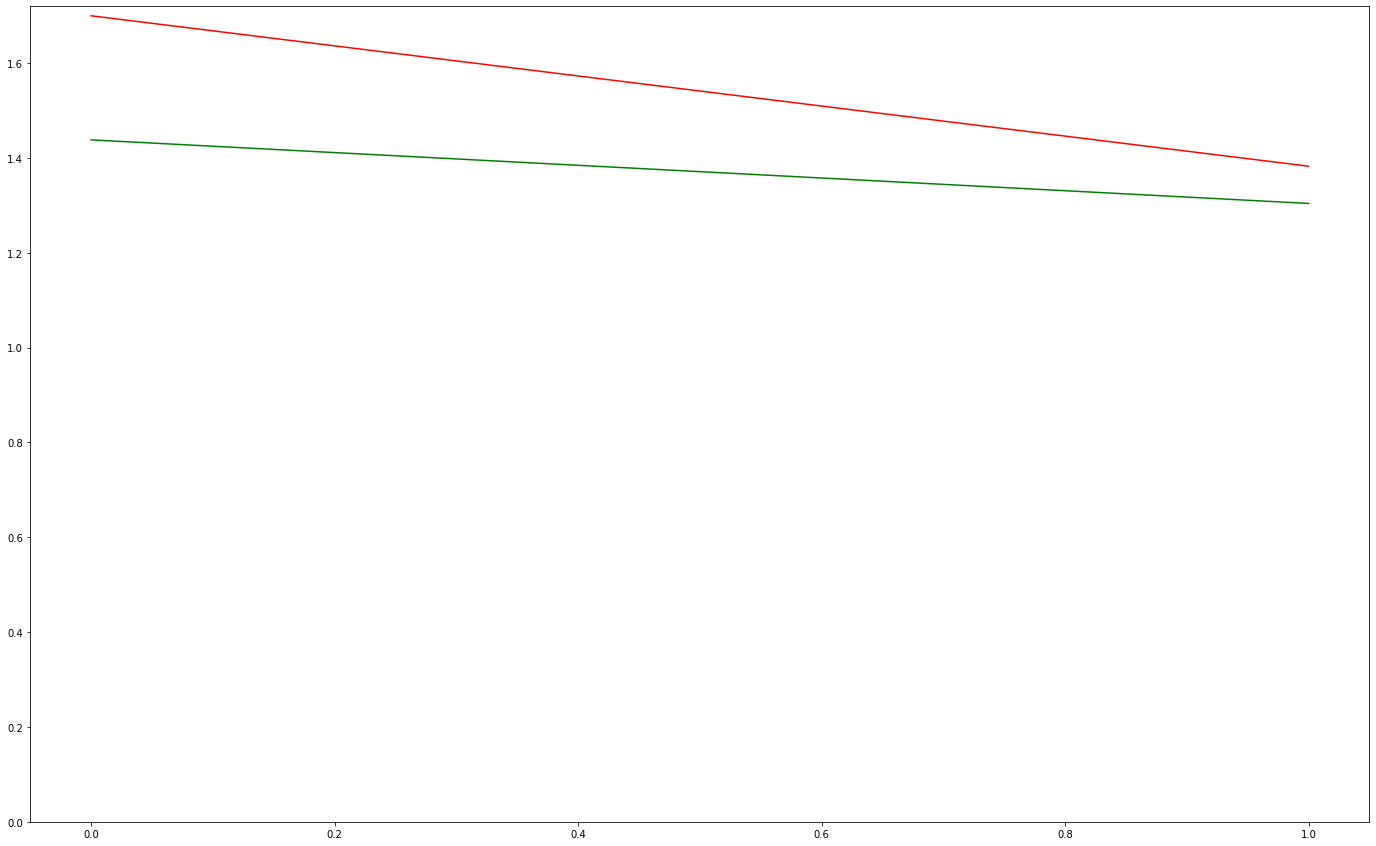

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.418306
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.463662
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.327178
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.077506
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.220102
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.511106
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.068282
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.155199
Test Epoch: 3 [0/10000 (0%)]	Loss: 1.101139
Test Epoch: 3 [6400/10000 (64%)]	Loss: 1.086436


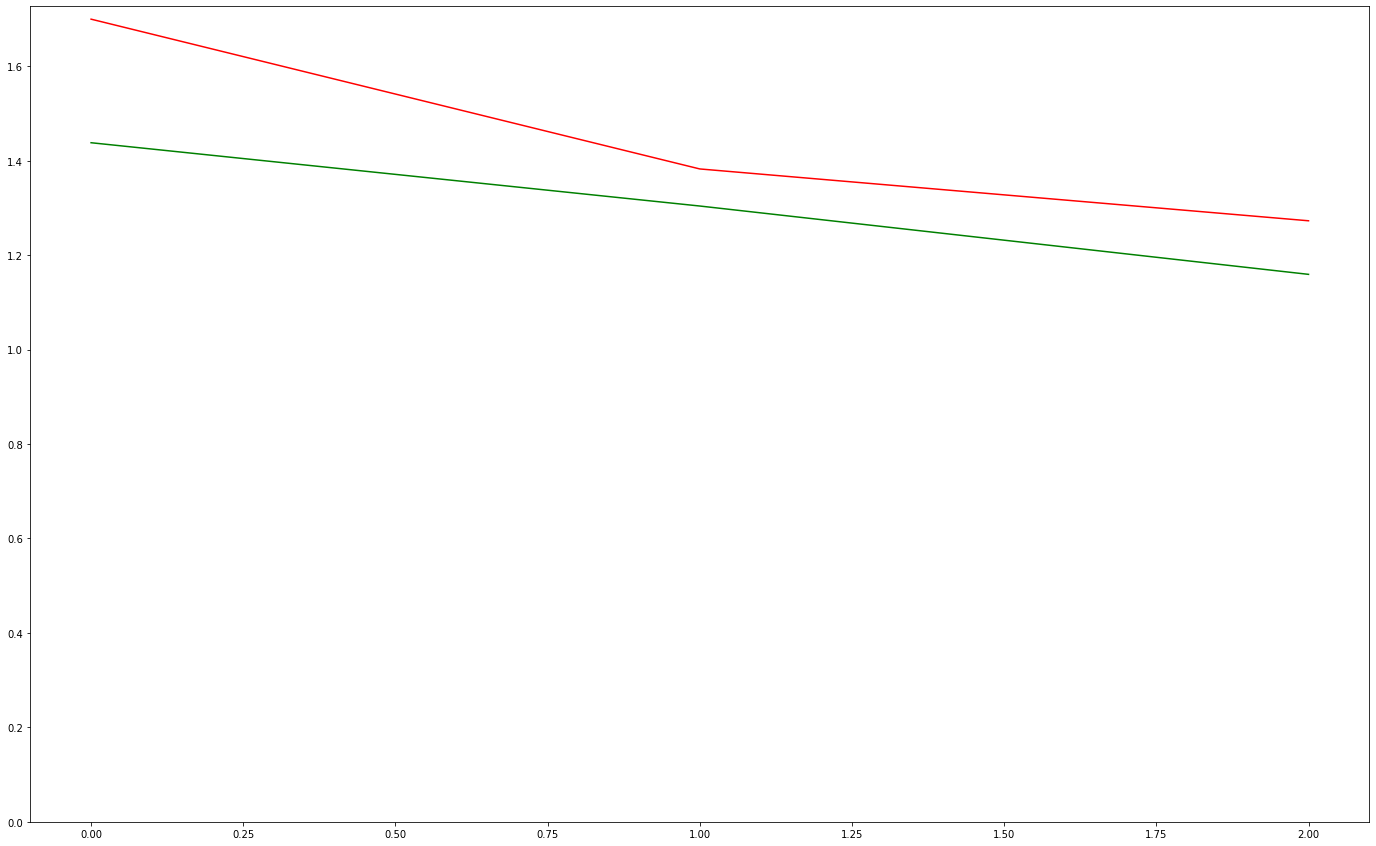

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.271974
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.297464
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.155688
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.058764
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.161967
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.152617
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.153831
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.428746
Test Epoch: 4 [0/10000 (0%)]	Loss: 1.007344
Test Epoch: 4 [6400/10000 (64%)]	Loss: 1.071574


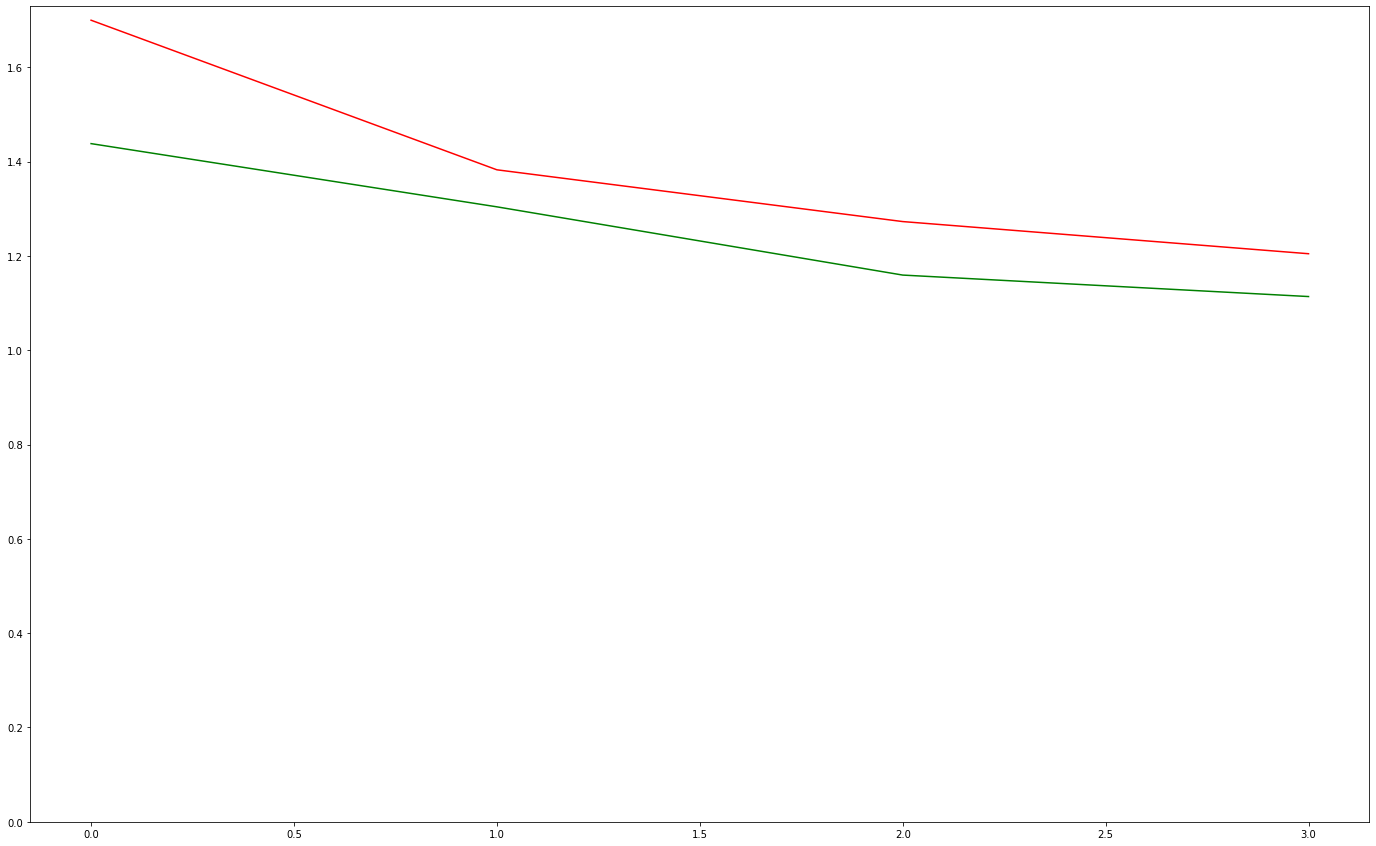

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.179909
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.116737
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.059931
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.077989
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.141721
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.391125
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.132713
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.071387
Test Epoch: 5 [0/10000 (0%)]	Loss: 1.271823
Test Epoch: 5 [6400/10000 (64%)]	Loss: 1.044503


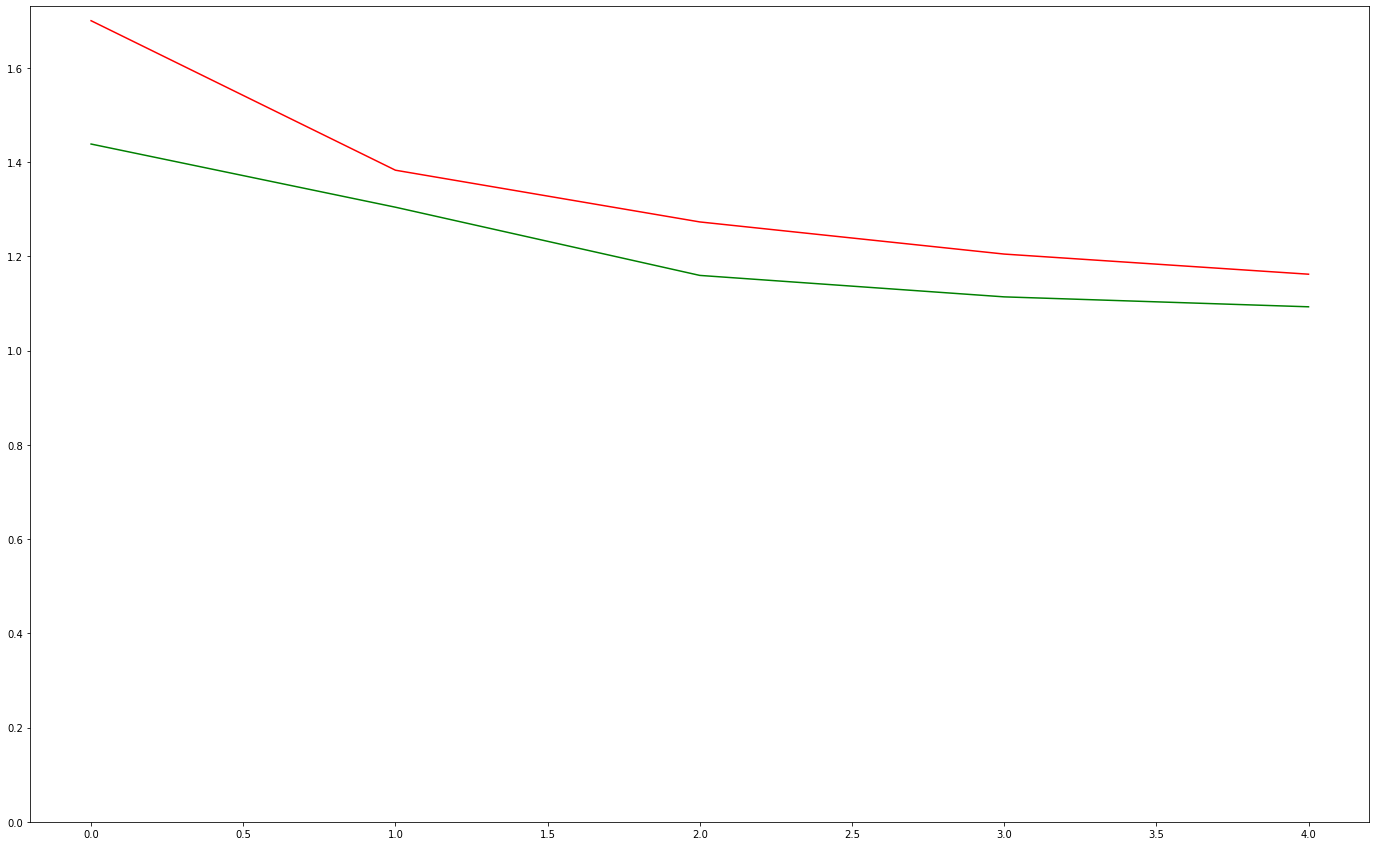

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.367797
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.122448
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.090147
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.108984
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.233543
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.169269
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.192995
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.396514
Test Epoch: 6 [0/10000 (0%)]	Loss: 0.954653
Test Epoch: 6 [6400/10000 (64%)]	Loss: 1.213346


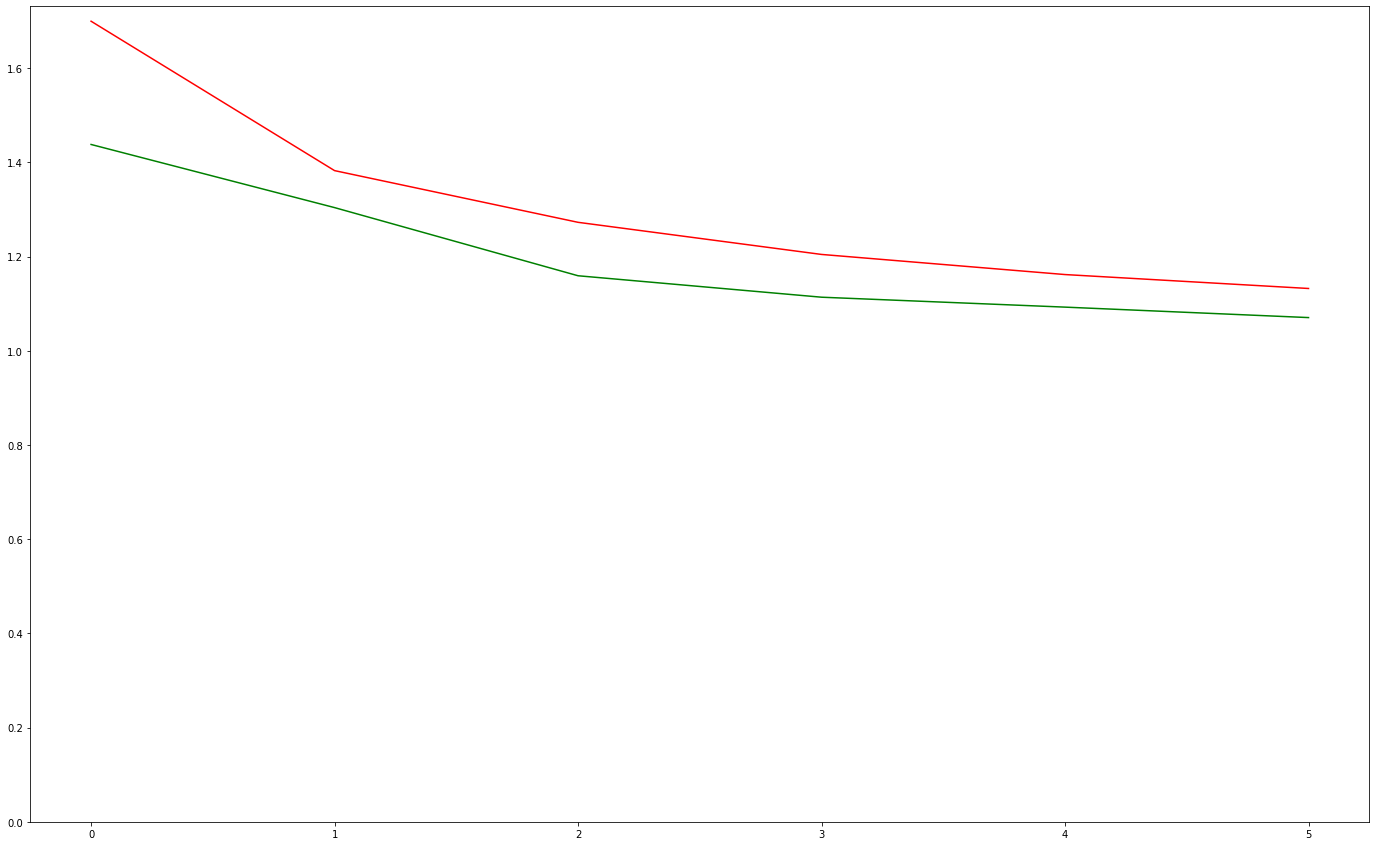

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.184498
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.106239
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.232550
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.246875
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.294542
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.106598
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.151704
Train Epoch: 7 [44800/50000 (90%)]	Loss: 1.093343
Test Epoch: 7 [0/10000 (0%)]	Loss: 0.999839
Test Epoch: 7 [6400/10000 (64%)]	Loss: 0.992472


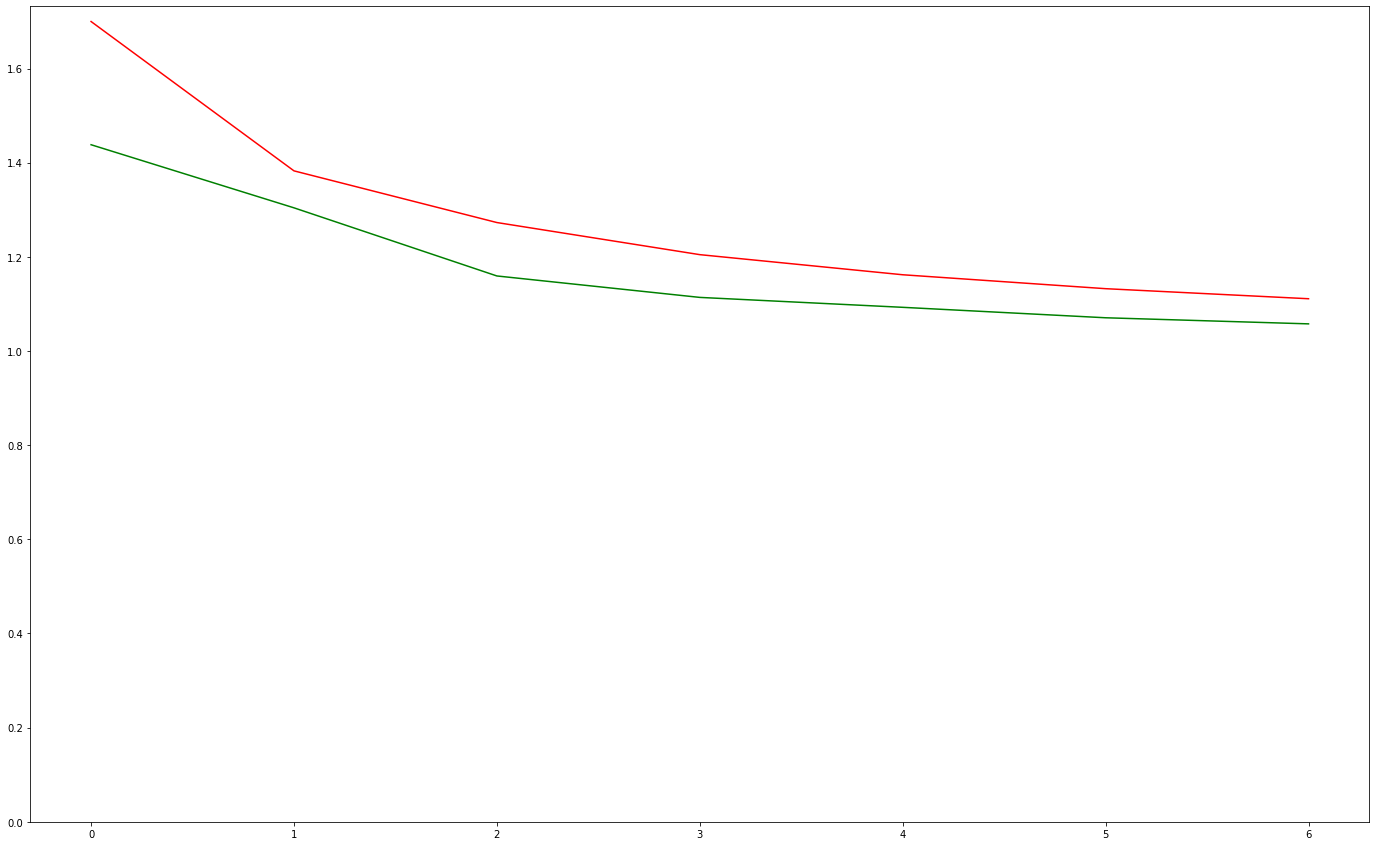

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.886080
Train Epoch: 8 [6400/50000 (13%)]	Loss: 1.194803
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.146307
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.008814
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.102347
Train Epoch: 8 [32000/50000 (64%)]	Loss: 1.115390
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.220919
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.164554
Test Epoch: 8 [0/10000 (0%)]	Loss: 1.102273
Test Epoch: 8 [6400/10000 (64%)]	Loss: 1.123804


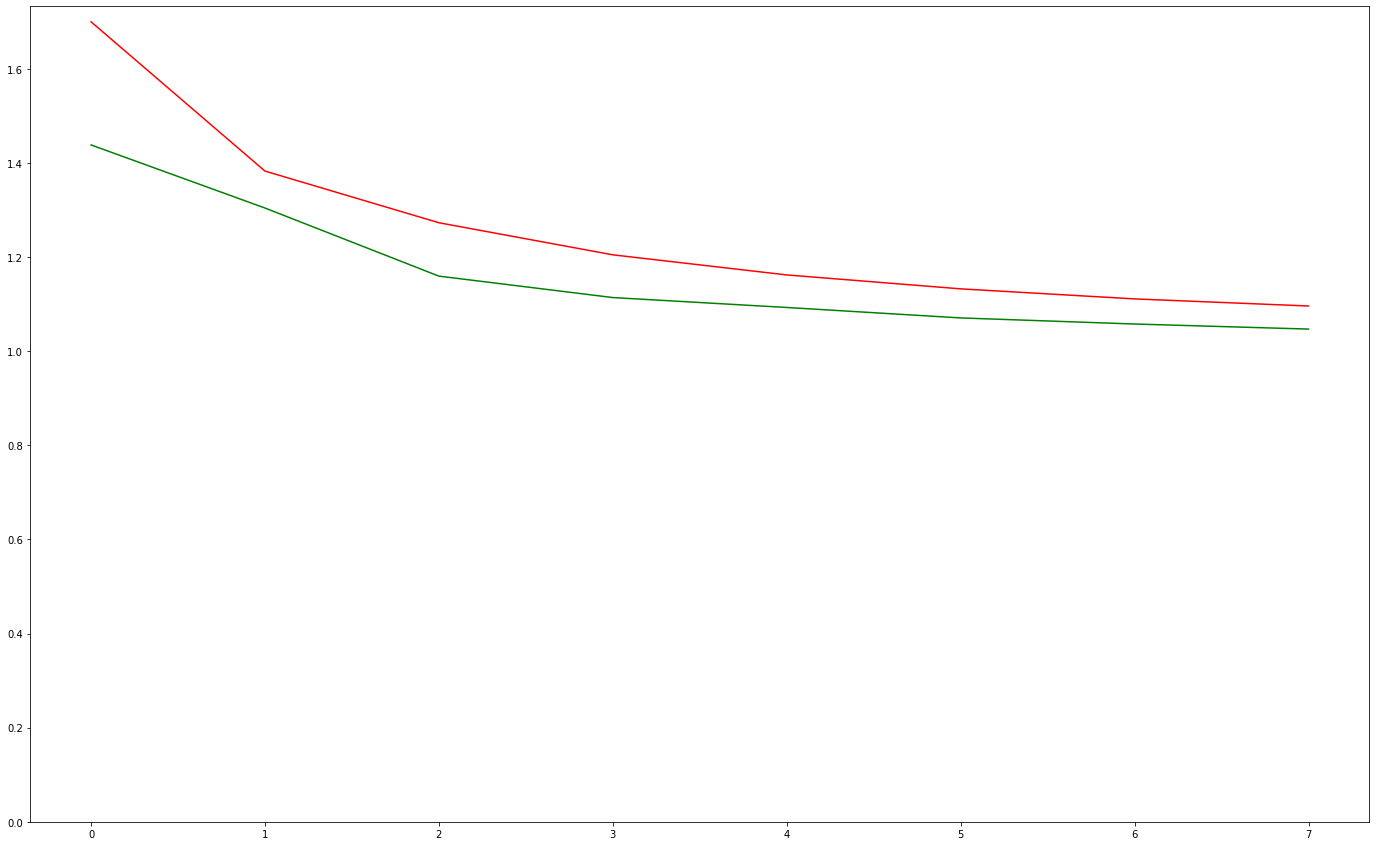

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.079433
Train Epoch: 9 [6400/50000 (13%)]	Loss: 1.031447
Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.049484
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.042646
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.038376
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.079062
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.247589
Train Epoch: 9 [44800/50000 (90%)]	Loss: 1.262995
Test Epoch: 9 [0/10000 (0%)]	Loss: 1.060593
Test Epoch: 9 [6400/10000 (64%)]	Loss: 1.006158


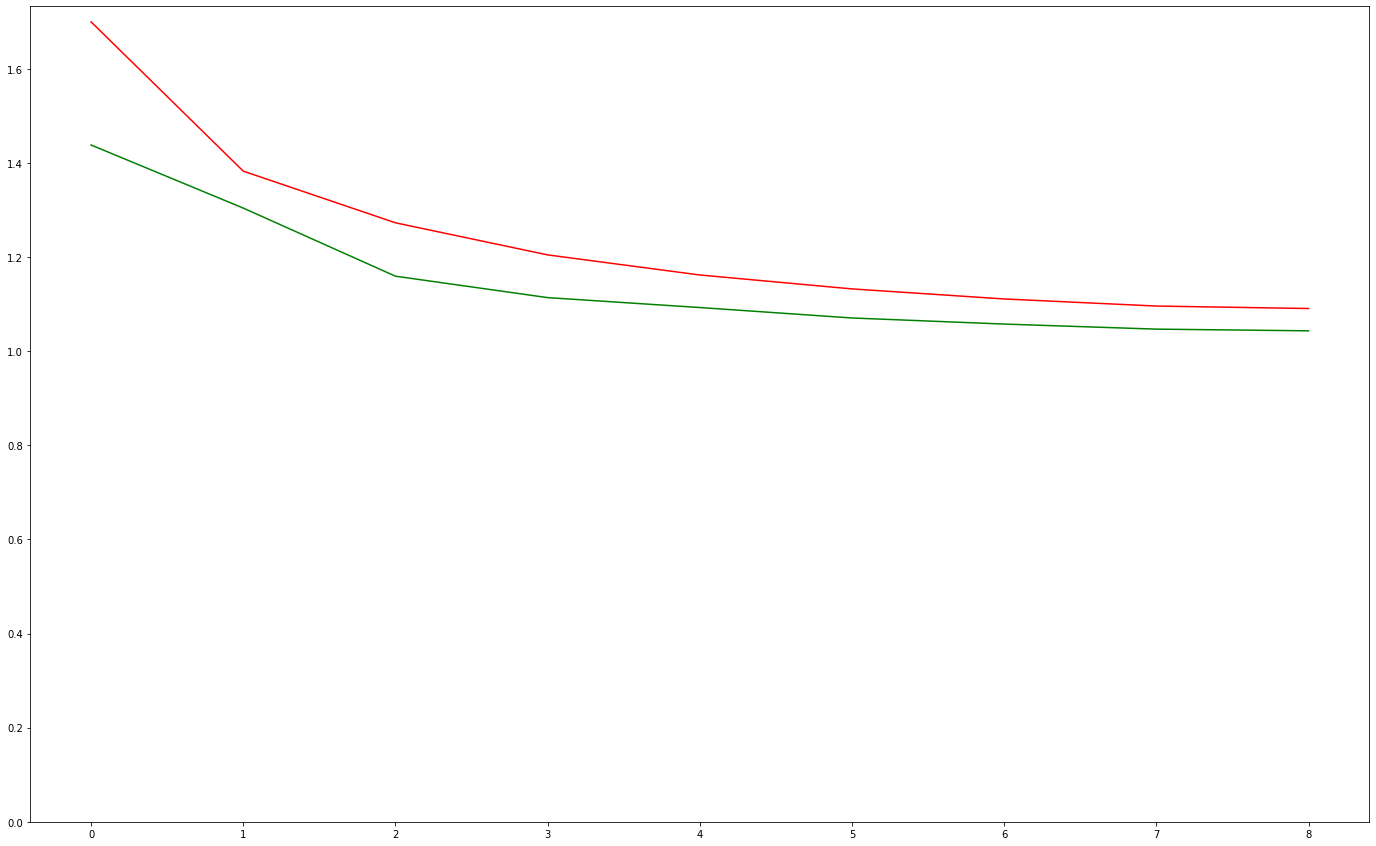

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.070363
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.284269
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.748385
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.939555
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.128664
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.050151
Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.962474
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.998865
Test Epoch: 10 [0/10000 (0%)]	Loss: 1.006997
Test Epoch: 10 [6400/10000 (64%)]	Loss: 1.027776


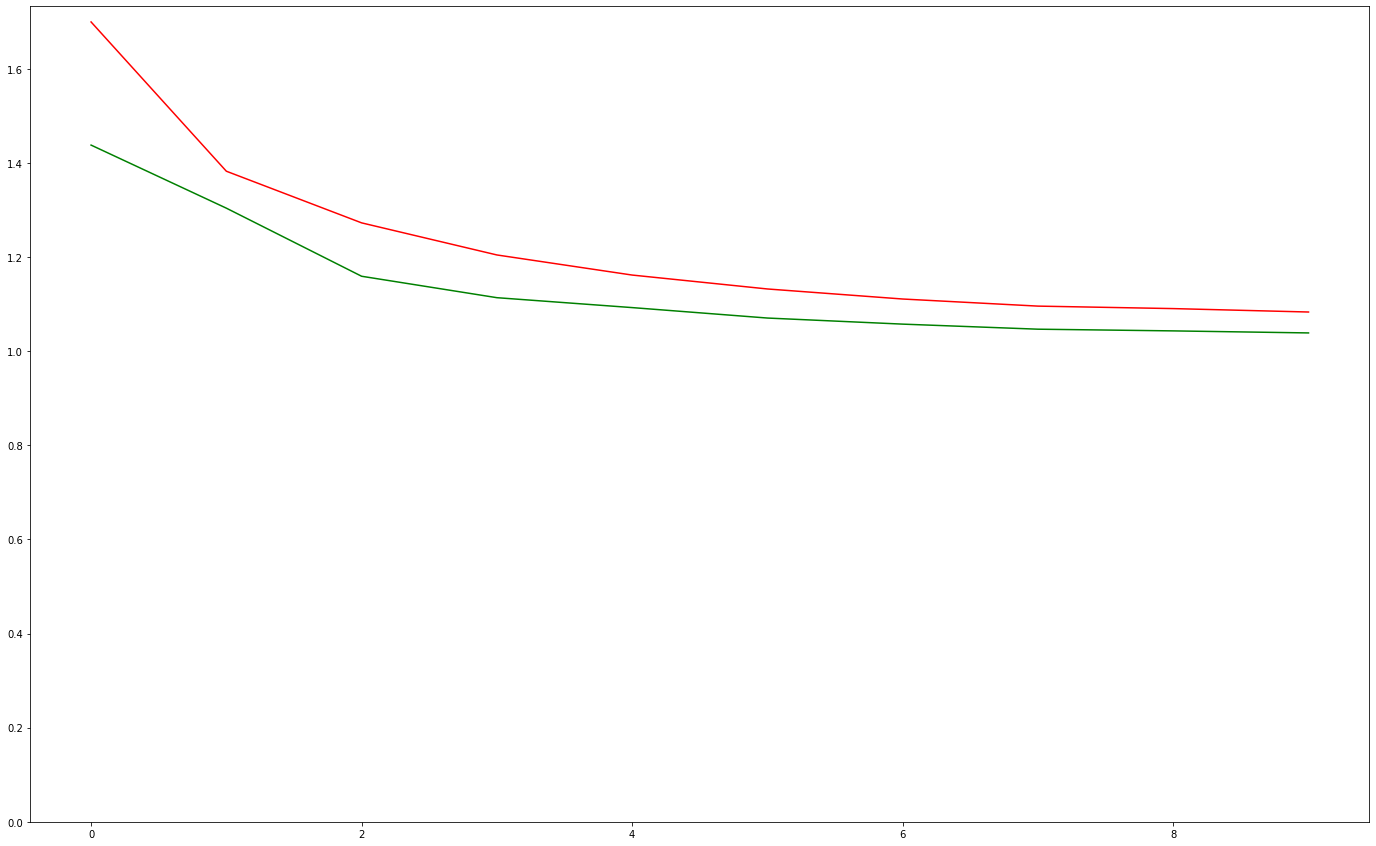

In [ ]:
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

#model = Simple_net(100, 10).to(device)
model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    train(model, device, test_loader, optimizer, epoch, log_interval, test_loss, False)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

In [ ]:
saveEntireModel(model, "CIFAR10.pth")

In [ ]:
loss_archive = []
test(model, device, test_loader, loss_archive)


Test set: Average loss: 1.0394, Accuracy: 6372/10000 (64%)



# Загадка

Эксперименты показали, что лосс теста всегда меньше лосса трейна из-за наличия Dropout'ов, предотвращающих переобучение.

График сети с Dropout'ами:

![](../data/imgs/assets/conv_dropouts.png)

График сети без Dropout'ов:

![](../data/imgs/assets/conv_no_dropouts.png)